# Building Models in PyMC3

As noted in the previous notebook, Bayesian inference begins with specification of a probability model relating unknown variables to data. PyMC3 provides the basic building blocks for Bayesian probability models: stochastic random variables, deterministic variables, and factor potentials.

A **stochastic random variable** is a factor whose value is not completely determined by its parents, while the value of a **deterministic random variable** is entirely determined by its parents. Most models can be constructed using only these two variable types. The third quantity, the **factor potential**, is *not* a variable but simply a
log-likelihood term or constraint that is added to the joint log-probability to modify it. 

## The FreeRV class

A stochastic variable is represented in PyMC3 by a `FreeRV` class. This structure adds functionality to Theano's `TensorVariable` class, by mixing in the PyMC `Factor` class. A `Factor` is used whenever a variable contributes a log-probability term to a model. Hence, you know a variable is a subclass of `Factor` whenever it has a `logp` method, as we saw in the previous section.

A `FreeRV` object has several important attributes:

`dshape`
:   The variable's shape.

`dsize`
:   The overall size of the variable.

`distribution`
:   The probability density or mass function that describes the distribution of the variable's values.

`logp`
:   The log-probability of the variable's current value given the values
    of its parents.

`init_value`
:   The initial value of the variable, used by many algorithms as a starting point for model fitting.

`model`
:   The PyMC model to which the variable belongs.


### Creation of stochastic random variables

There are two ways to create stochastic random variables (`FreeRV` objects), which we will call the **automatic**, and **manual** interfaces.

#### Automatic

Stochastic random variables with standard distributions provided by PyMC3 can be created in a single line using special subclasses of the `Distribution` class. For example, as we have seen, the uniformly-distributed discrete variable $switchpoint$ in the coal mining disasters model is created using the automatic interface as follows:

In [1]:
import pymc3 as pm

with pm.Model() as disaster_model:

    switchpoint = pm.DiscreteUniform('switchpoint', lower=0, upper=110)

/Users/vejmelka/Packages/anaconda/envs/bayes/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Similarly, the rate parameters can automatically be given exponential priors:

In [2]:
with disaster_model:
    early_mean = pm.Exponential('early_mean', lam=1)
    late_mean = pm.Exponential('late_mean', lam=1)

PyMC includes most of the probability density functions (for continuous variables) and probability mass functions (for discrete variables) used in statistical modeling. Continuous variables are represented by a specialized subclass of `Distribution` called `Continuous` and discrete variables by the `Discrete` subclass.

The main differences between these two sublcasses are in the `dtype` attribute (`int64` for `Discrete` and `float64` for `Continuous`) and the `defaults` attribute, which determines which summary statistic to use for initial values when one is not specified ('mode' for `Discrete` and 'median', 'mean', and 'mode' for `Continuous`).

In [3]:
switchpoint.distribution.defaults

('mode',)

As we previewed in the introduction, `Distribution` has a class method `dist` that returns a probability distribution of that type, without being wrapped in a PyMC random variable object. Sometimes we wish to use a particular statistical distribution, without using it as a variable in a model; for example, to generate random numbers from the distribution. This class method allows that.

In [4]:
pm.Exponential.dist(1)

#### Manual

The uniformly-distributed discrete stochastic variable `switchpoint` in the disasters model could alternatively be created from a function that computes its log-probability as follows:

In [5]:
import theano.tensor as tt

In [6]:
import numpy as np
from pymc3.math import switch, log

with pm.Model():  

    
    def uniform_logp(value, lower=0, upper=111):
        """The switchpoint for the rate of disaster occurrence."""
        return switch((value > upper) | (value < lower), -np.inf, -log(upper - lower + 1))

    switchpoint = pm.DensityDist('switchpoint', logp=uniform_logp, dtype='int64')

In [7]:
switchpoint.logp({'switchpoint':4})

array(-4.7184987, dtype=float32)

In [8]:
switchpoint.logp({'switchpoint': 44})

array(-4.7184987, dtype=float32)

In [9]:
switchpoint.logp({'switchpoint':-1})

array(-inf, dtype=float32)

A couple of things to notice: while the function specified for the `logp` argument can be an arbitrary Python function, it must use **Theano operators and functions** in its body. This is because one or more of the arguments passed to the function may be `TensorVariables`, and they must be supported. Also, we passed the value to be evaluated by the `logp` function as a **dictionary**, rather than as a plain integer. By convention, values in PyMC3 are passed around as a data structure called a `Point`. Points in parameter space are represented by dictionaries with parameter names as they keys and the value of the parameters as the values.

To emphasize, the Python function passed to `DensityDist` should compute the *log*-density or *log*-probability of the variable. That is why the return value in the example above is `-log(upper-lower+1)` rather than `1/(upper-lower+1)`.

### Specifying Custom Distributions

Similarly, the library of statistical distributions in PyMC3 is not exhaustive, but PyMC allows for the creation of user-defined functions for an **arbitrary probability distribution**. For simple statistical distributions, the `DensityDist` function takes as an argument any function that calculates a log-probability $log(p(x))$. This function may employ other random variables in its calculation. 


Here is a simple example inspired by a blog post by Jake Vanderplas (Vanderplas, 2014), where Jeffreys priors are used to specify priors that are invariant to transformation. In the case of simple linear regression, these are:

$$\beta \propto (1+\beta^2)^{3/2}$$

$$\sigma \propto \frac{1}{\alpha}$$

The logarithms of these functions can be specified as the argument to DensityDist and inserted into the model.

```python
import theano.tensor as T
from pymc3 import DensityDist, Uniform

with Model() as model:
    alpha = Uniform('intercept', -100, 100)
    
    # Create custom densities
    beta = DensityDist('beta', lambda value: -1.5 * T.log(1 + value**2), testval=0)
    eps = DensityDist('eps', lambda value: -T.log(T.abs_(value)), testval=1)
    
    # Create likelihood
    like = Normal('y_est', mu=alpha + beta * X, sd=eps, observed=Y)
```

For more complex distributions, one can create a subclass of `Continuous` or `Discrete` and provide the custom `logp` function, as required. This is how the built-in distributions in PyMC are specified. As an example, fields like psychology and astrophysics have complex likelihood functions for a particular process that may require numerical approximation. In these cases, it is impossible to write the function in terms of predefined theano operators and we must use a custom theano operator using `as_op` or inheriting from `theano.Op`. 

Implementing the `beta` variable above as a `Continuous` subclass is shown below, along with a sub-function using the `as_op` decorator, though this is not strictly necessary.

In [10]:
from pymc3.distributions import Continuous
import theano.tensor as tt
from theano import as_op

class Beta(Continuous):
    def __init__(self, mu, *args, **kwargs):
        super(Beta, self).__init__(*args, **kwargs)
        self.mu = mu
        self.mode = mu

    def logp(self, value):
        mu = self.mu
        return beta_logp(value - mu)
    
@as_op(itypes=[tt.dscalar], otypes=[tt.dscalar])
def beta_logp(value):
    return -1.5 * np.log(1 + (value)**2)


with pm.Model() as model:
    beta = Beta('slope', mu=0, testval=0)

## The ObservedRV Class

Stochastic random variables whose values are observed (*i.e.* data likelihoods) are represented by a different class than unobserved random variables. A `ObservedRV` object is instantiated any time a stochastic variable is specified with data passed as the `observed` argument. 

Otherwise, observed stochastic random variables are created via the same interfaces as unobserved: **automatic** or **manual**. As an example of an automatic instantiation, consider a Poisson data likelihood :

In [11]:
with disaster_model:
    
    disasters = pm.Poisson('disasters', mu=3, observed=[3,4,1,2,0,2,2])

We have already seen manual instantiation, from the melanoma survial model where the exponential survival likelihood was implemented manually:

```python
def logp(failure, value):
    return (failure * log(lam) - lam * value).sum()

x = DensityDist('x', logp, observed={'failure':failure, 'value':t})
```

Notice in this example that there are two vetors observed data for the likelihood `x`, passed as a dictionary.

An important responsibility of `ObservedRV` is to automatically handle missing values in the data, when they are present (absent?). More on this later.

## Deterministic Variables

A deterministic variable is one whose values are **completely determined** by the values of their parents. For example, in our disasters model, `rate` is a deterministic variable.

In [12]:
with disaster_model:
    
    rate = pm.Deterministic('rate', switch(switchpoint >= np.arange(112), early_mean, late_mean))

so `rate`'s value can be computed exactly from the values of its parents `early_mean`, `late_mean` and `switchpoint`.

There are two types of deterministic variables in PyMC3

#### Anonymous deterministic variables

The easiest way to create a deterministic variable is to operate on or transform one or more variables in a model directly. For example, the simplest way to specify the `rate` variable above is as follows:

In [13]:
with disaster_model:
    
    rate = switch(switchpoint >= np.arange(112), early_mean, late_mean)

Or, let's say we wanted to use the mean of the `early_mean` and `late_mean` variables somehere in our model:

In [14]:
with disaster_model:
    
    diff_means = pm.Deterministic('diff_means', early_mean - late_mean)

These are called *anonymous* variables because we did not wrap it with a call to `Determinstic`, which gives it a name as its first argument. We simply specified the variable as a Python (or, Theano) expression. This is therefore the simplest way to construct a determinstic variable. The only caveat is that the values generated by anonymous determinstics at every iteration of a MCMC algorithm, for example, are not recorded to the resulting trace. So, this approach is only appropriate for intermediate values in your model that you do not wish to obtain posterior estimates for, alongside the other variables in the model.

#### Named deterministic variables

To ensure that deterministic variables' values are accumulated during sampling, they should be instantiated using the **named deterministic** interface; this uses the `Deterministic` function to create the variable. Two things happen when a variable is created this way:

1. The variable is given a name (passed as the first argument)
2. The variable is appended to the model's list of random variables, which ensures that its values are tallied.


```python
with disaster_model:
    
    rate = pm.Deterministic('rate', switch(switchpoint >= np.arange(112), early_mean, late_mean))
```

In [15]:
disaster_model.named_vars

{'diff_means': diff_means,
 'disasters': disasters,
 'early_mean': early_mean,
 'early_mean_log__': early_mean_log__,
 'late_mean': late_mean,
 'late_mean_log__': late_mean_log__,
 'rate': rate,
 'switchpoint': switchpoint}

## Factor Potentials

For some applications, we want to be able to modify the joint density by incorporating terms that don't correspond to probabilities of variables conditional on parents, for example:

$$p(x_0, x_2, \ldots x_{N-1}) \propto \prod_{i=0}^{N-2} \psi_i(x_i, x_{i+1})$$

In other cases we may want to add probability terms to existing models. For example, suppose we want to constrain the difference between the early and late means in the disaster model to be less than 1, so that the joint density becomes: 

$$p(y,\tau,\lambda_1,\lambda_2) \propto p(y|\tau,\lambda_1,\lambda_2) p(\tau) p(\lambda_1) p(\lambda_2) I(|\lambda_2-\lambda_1| \lt 1)$$

We call such log-probability terms **factor potentials** (Jordan 2004). Bayesian
hierarchical notation doesn't accomodate these potentials. 

### Creation of Potentials

A potential can be created via the `Potential` function, in a way very similar to `Deterministic`'s named interface:

In [16]:
with disaster_model:
    
    rate_constraint = pm.Potential('rate_constraint', switch(pm.math.abs_(early_mean-late_mean)>1, -np.inf, 0))

The function takes just a `name` as its first argument and an expression returning the appropriate log-probability as the second argument.

A common use of a factor potential is to represent an observed likelihood, where the **observations are partly a function of model variables**. In the contrived example below, we are representing the error in a linear regression model as a zero-mean normal random variable. Thus, the "data" in this scenario is the residual, which is a function both of the data and the regression parameters.

Note that in the future, factor potentials will be key in studying *probabilistic graphical models*, which can in some cases be built from *factor graphs* (= products of factor potentials).  Thus getting familiar with the concept will also help us in the future.

In [17]:
y = np.array([15, 10, 16, 11, 9, 11, 10, 18, 11])
x = np.array([1, 2, 4, 5, 6, 8, 19, 18, 12])

with pm.Model() as arma_model:

    sigma = pm.HalfCauchy('sigma', 5)
    beta = pm.Normal('beta', 0, sd=2)
    mu = pm.Normal('mu', 0, sd=10)

    err = y - (mu + beta*x)
                  
    like = pm.Potential('like', pm.Normal.dist(0, sd=sigma).logp(err))

## PW Exercise

### Backstory
For me, one of the cool things done with Byesian modelling was the construction of the TrueSkill system for Microsoft Xbox online gaming system by Tom Minka from Microsoft Research.  The objective of TrueSkill is simple: as quickly as possible match a player with players of similar skill with whom it will be most fun to play.  To reach this objective, the TS system must estimate each players quality as fast as possible.  This is done in real-time using expectation propagation (not in scope of this tutorial), and the paper shows the results compared to e.g. chess ELO - and they're impressive.

### A 2-player trueskill

Let us begin with a prior distribution.  We will suppose that each player has a skill score that determines the true skill in playing the game (here we assume the skill has the same units as the relative score in the game).  The difference in skill is an estimate of the actual difference in the score of the game BUT each game is also affected by random chance, thus the difference is modeled as a normal distribution centered around the difference in skill with a variance $\sigma_s$.

Our prior for each players skill score is $\mu_i \sim {\cal N}(\mu_0, \sigma_0^2)$, where $\mu_0 = 100$ and $\sigma_0 = 8$.

We assume that we have observed four games with the final score differences noted in `score_diff_obs`.

In [53]:
# The differences in game scores.
score_diff_obs = [-10, -16, 4, -8]

In [63]:
with pm.Model() as trueskill_tiny:
    
    mu0, sigma0 = 100, 8
    sigma_s = 8
    
    mu1 = pm.Normal('mu1', mu0, sigma0)
    mu2 = pm.Normal('mu2', mu0, sigma0)
    
    delta_mu = pm.Deterministic('delta_mu', mu1 - mu2)
    
    score_diff = pm.Normal('score_diff', delta_mu, sigma_score, observed = score_diff_obs)

In [62]:
with trueskill_tiny:
    model_map = pm.find_MAP()
    
print(model_map)

logp = -21.397, ||grad|| = 0.66291: 100%|██████████| 4/4 [00:00<00:00, 1081.35it/s]

{'mu1': array(96.66666667), 'mu2': array(103.33333333), 'delta_nu': array(-6.66666667)}


In [56]:
with trueskill_tiny:
    trace = pm.sample(draws = 4000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/vejmelka/Packages/anaconda/envs/bayes/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|██████████| 4500/4500 [00:04<00:00, 1091.13it/s]


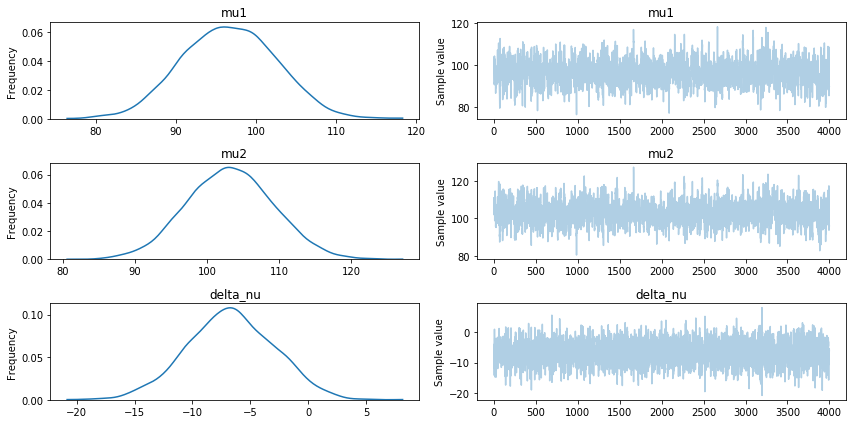

In [59]:
_ = pm.traceplot(trace)

### Cool right?
We can infer the changes to the skills of the individual players based on the result of the game.

### Question
- What would happen if the prior for one of the players was tighter (smaller variance)?  This could happen if we have already seen this player playing someone else before and we have some information about him.

## Exercise

Assume that instead of observing game score differences, you only observe who wins and/or loses the game.  How would you modify the model for this new situation?

You observe only $[-1, 0, 1]$, which stands for player 1 loss, draw, player 1 win.  Build a plausible model for this situation.

You may have to use a factor potential or perhaps one of the distributions could come in handy.

## References

1. Ching & Chen. 2007. Transitional Markov chain Monte Carlo method for Bayesian model updating, model class selection and model averaging. Journal of Engineering Mechanics 2007
2.	Hoffman MD, Gelman A. 2014. The No-U-turn sampler: adaptively setting path lengths in Hamiltonian Monte Carlo. The Journal of Machine Learning Research. 15(1):1593-1623.
3. M.I. Jordan. 2004. Graphical models. Statist. Sci., 19(1):140–155.
4. Neal, R. M. 2003. Slice sampling. The Annals of Statistics, 31(3), 705–767. doi:10.1111/1467-9868.00198
5. VanderPlas, J. (2014). Frequentism and bayesianism: A python-driven primer. arXiv preprint arXiv:1411.5018.